<a href="https://colab.research.google.com/github/Gressling/digitalchemistry.org/blob/main/batch_analysis/Batch_analysis%2C_optimum_of_T_and_pH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sqlite3

# Create a connection to the Knowledge Graph database
conn_kg = sqlite3.connect('knowledge_graph.db')
cursor_kg = conn_kg.cursor()

# Create tables for Knowledge Graph
cursor_kg.execute("""
    CREATE TABLE IF NOT EXISTS reactions (
        id INTEGER PRIMARY KEY,
        name TEXT
    )
""")
cursor_kg.execute("INSERT INTO reactions (name) VALUES ('Nitration of Benzene')")

# Commit changes
conn_kg.commit()


In [2]:
# Create a connection to the Execution Layer database
conn_exec = sqlite3.connect('execution_layer.db')
cursor_exec = conn_exec.cursor()

# Create tables for Execution Layer
cursor_exec.execute("""
    CREATE TABLE IF NOT EXISTS batches (
        id INTEGER PRIMARY KEY,
        date_time TEXT,
        actual_yield REAL
    )
""")
cursor_exec.execute("""
    CREATE TABLE IF NOT EXISTS batch_parameters (
        id INTEGER PRIMARY KEY,
        batch_id INTEGER,
        temperature REAL,
        pressure REAL,
        pH REAL,
        mixing_speed REAL,
        FOREIGN KEY (batch_id) REFERENCES batches (id)
    )
""")
cursor_exec.execute("""
    CREATE TABLE IF NOT EXISTS batch_quality_attributes (
        id INTEGER PRIMARY KEY,
        batch_id INTEGER,
        purity REAL,
        potency TEXT,
        stability TEXT,
        FOREIGN KEY (batch_id) REFERENCES batches (id)
    )
""")

# Function to calculate actual yield based on temperature and pH
def calculate_yield(temperature, pH):
    temp_effect = (temperature - 55) * 0.5
    pH_effect = (pH - 2.5) * -1.5
    yield_effect = temp_effect + pH_effect
    actual_yield = min(max(90 + yield_effect, 70), 100)
    return actual_yield

import random

# Insert Batch Parameters and Quality Attributes with variations
for batch_id in range(1, 11):
    temperature = 55 + random.uniform(-3, 3)  # Random variation around 55°C
    pH = 2.5 + random.uniform(-0.5, 0.5)      # Random variation around 2.5
    actual_yield = calculate_yield(temperature, pH)
    date_time = f'2023-08-{10 + batch_id} 10:00:00'

    cursor_exec.execute("INSERT INTO batches (date_time, actual_yield) VALUES (?, ?)", (date_time, actual_yield))
    cursor_exec.execute("INSERT INTO batch_parameters (batch_id, temperature, pressure, pH, mixing_speed) VALUES (?, ?, 1.5, ?, 250)", (batch_id, temperature, pH))
    cursor_exec.execute("INSERT INTO batch_quality_attributes (batch_id, purity, potency, stability) VALUES (?, 98.5, 'High', 'Stable')", (batch_id,))

# Commit changes
conn_exec.commit()


In [3]:
# Join the batches, batch_parameters, and batch_quality_attributes tables
query = """
    SELECT
        b.date_time, b.actual_yield,
        bp.temperature, bp.pressure, bp.pH, bp.mixing_speed,
        bqa.purity, bqa.potency
    FROM batches AS b
    JOIN batch_parameters AS bp ON b.id = bp.batch_id
    JOIN batch_quality_attributes AS bqa ON b.id = bqa.batch_id
"""

cursor_exec.execute(query)
data = cursor_exec.fetchall()


In [4]:
date_times, actual_yields, temperatures, pressures, pHs, mixing_speeds, purities, potencies = zip(*data)


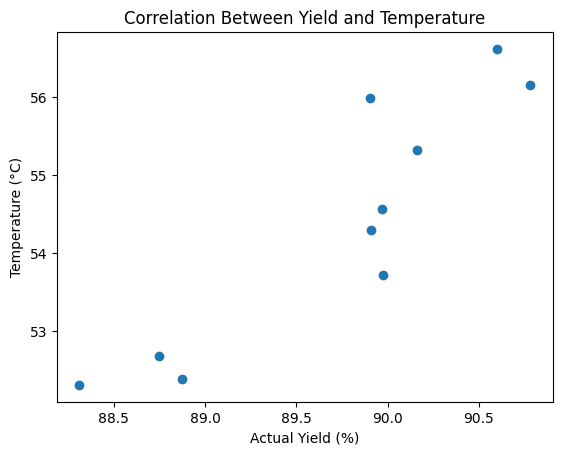

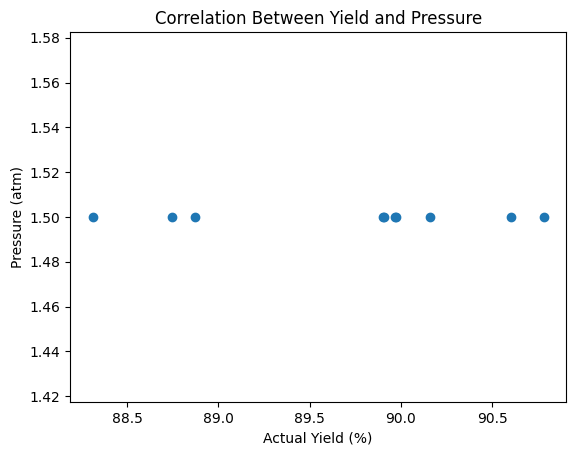

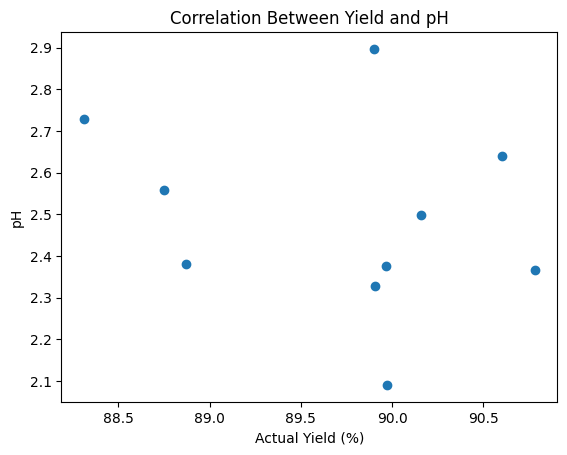

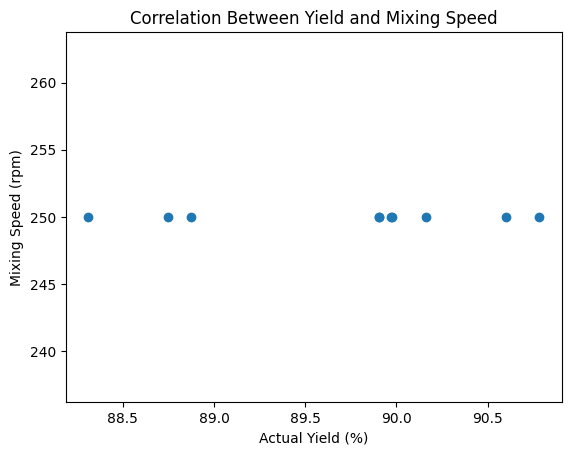

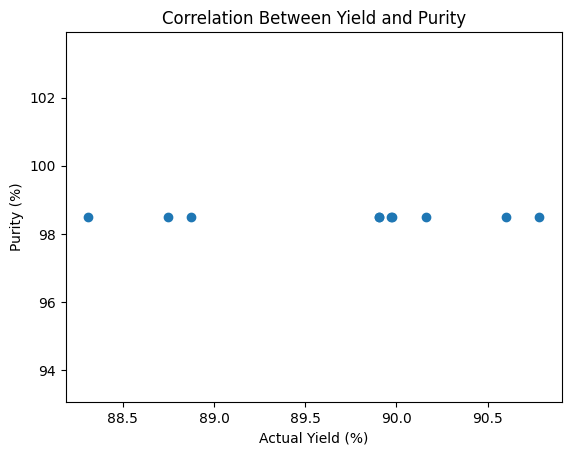

In [5]:
import matplotlib.pyplot as plt

# Function to create a scatter plot
def create_scatter_plot(x, y, x_label, y_label, title):
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

# Plot correlations
create_scatter_plot(actual_yields, temperatures, 'Actual Yield (%)', 'Temperature (°C)', 'Correlation Between Yield and Temperature')
create_scatter_plot(actual_yields, pressures, 'Actual Yield (%)', 'Pressure (atm)', 'Correlation Between Yield and Pressure')
create_scatter_plot(actual_yields, pHs, 'Actual Yield (%)', 'pH', 'Correlation Between Yield and pH')
create_scatter_plot(actual_yields, mixing_speeds, 'Actual Yield (%)', 'Mixing Speed (rpm)', 'Correlation Between Yield and Mixing Speed')
create_scatter_plot(actual_yields, purities, 'Actual Yield (%)', 'Purity (%)', 'Correlation Between Yield and Purity')


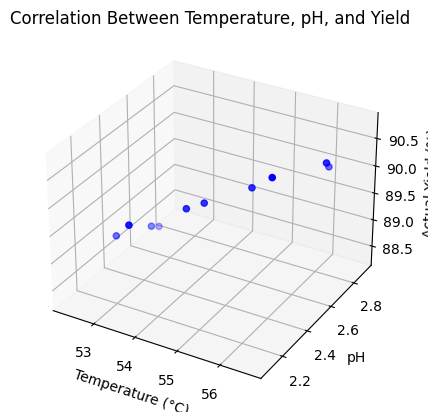

(55.0, 2.5, 90.0)

In [6]:
# Importing required libraries for statistical analysis
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# Query to get the batch data with temperature, pH, and actual yield
query = """
    SELECT
        bp.temperature, bp.pH, b.actual_yield
    FROM batches AS b
    JOIN batch_parameters AS bp ON b.id = bp.batch_id
"""

# Execute the query
cursor_exec.execute(query)
batch_data = cursor_exec.fetchall()

# Extracting temperature, pH, and actual yield
temperatures, pHs, actual_yields = zip(*batch_data)

# Function to model the yield based on temperature and pH
def yield_model(params, temperatures, pHs, actual_yields):
    temp_optimum, pH_optimum, base_yield = params
    predicted_yields = base_yield + (temperatures - temp_optimum) * 0.5 + (pHs - pH_optimum) * -1.5
    return np.sum((predicted_yields - actual_yields) ** 2)

# Minimizing the model to find the optimum temperature and pH
result = minimize(yield_model, [55, 2.5, 90], args=(temperatures, pHs, actual_yields))
optimum_temperature, optimum_pH, optimum_yield = result.x

# Plotting the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(temperatures, pHs, actual_yields, c='b', marker='o', label='Actual Yield')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('pH')
ax.set_zlabel('Actual Yield (%)')
ax.set_title('Correlation Between Temperature, pH, and Yield')
plt.show()

# Return the optimum temperature, pH, and yield
optimum_temperature, optimum_pH, optimum_yield


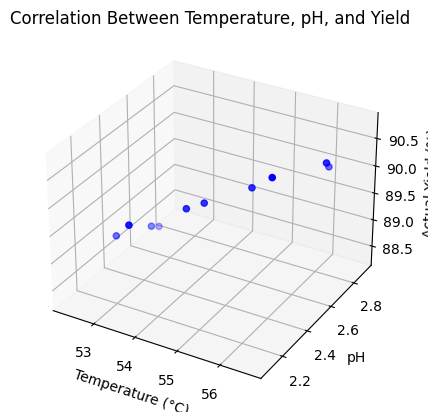

Optimum Temperature: 55.0°C
Optimum pH: 2.5
Optimum Yield: 90.0%


In [7]:
# Plotting the result in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(temperatures, pHs, actual_yields, c='b', marker='o', label='Actual Yield')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('pH')
ax.set_zlabel('Actual Yield (%)')
ax.set_title('Correlation Between Temperature, pH, and Yield')
plt.show()

# Print the optimum temperature, pH, and yield
print(f'Optimum Temperature: {optimum_temperature}°C')
print(f'Optimum pH: {optimum_pH}')
print(f'Optimum Yield: {optimum_yield}%')

In [8]:
import plotly.express as px
import pandas as pd


In [9]:
# Create a DataFrame with the batch data (temperature, pH, and actual yield)
batch_data_df = pd.DataFrame({
    'Temperature (°C)': temperatures,
    'pH': pHs,
    'Actual Yield (%)': actual_yields
})


In [10]:
# Create the 3D scatter plot using Plotly Express
fig = px.scatter_3d(batch_data_df, x='Temperature (°C)', y='pH', z='Actual Yield (%)', opacity=0.7)

# Customize the plot
fig.update_layout(title='Correlation Between Temperature, pH, and Yield',
                  scene=dict(xaxis_title='Temperature (°C)',
                             yaxis_title='pH',
                             zaxis_title='Actual Yield (%)'),
                  margin=dict(l=0, r=0, b=0, t=0))

# Show the plot
fig.show()


In [11]:
# Print the optimum temperature, pH, and yield
print(f'Optimum Temperature: {optimum_temperature}°C')
print(f'Optimum pH: {optimum_pH}')
print(f'Optimum Yield: {optimum_yield}%')

Optimum Temperature: 55.0°C
Optimum pH: 2.5
Optimum Yield: 90.0%


In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


In [13]:
# Prepare the input data (temperature and pH) and target (actual yield)
X = np.column_stack((temperatures, pHs))
y = np.array(actual_yields)


In [14]:
# Create a polynomial model of degree 2
polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Fit the model to the data
polynomial_model.fit(X, y)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

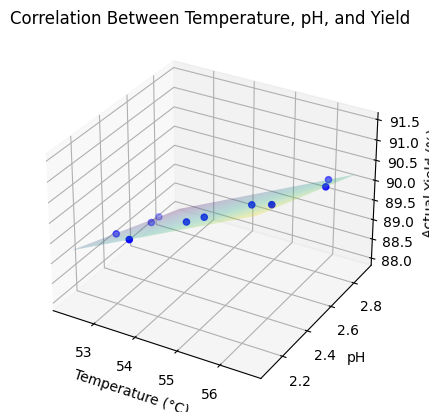

In [15]:
# Generate a meshgrid for temperature and pH to visualize the surface
temp_range = np.linspace(min(temperatures), max(temperatures), 100)
pH_range = np.linspace(min(pHs), max(pHs), 100)
temp_mesh, pH_mesh = np.meshgrid(temp_range, pH_range)
X_mesh = np.column_stack((temp_mesh.ravel(), pH_mesh.ravel()))

# Predict the yield using the polynomial model
predicted_yield_mesh = polynomial_model.predict(X_mesh).reshape(temp_mesh.shape)

# Plot the actual and predicted data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(temperatures, pHs, actual_yields, c='b', marker='o', label='Actual Yield')
ax.plot_surface(temp_mesh, pH_mesh, predicted_yield_mesh, alpha=0.3, cmap='viridis')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('pH')
ax.set_zlabel('Actual Yield (%)')
ax.set_title('Correlation Between Temperature, pH, and Yield')
plt.show()


In [16]:
# Importing Plotly libraries
import plotly.graph_objects as go

# Preparing the data for polynomial modeling
X = np.column_stack((temperatures, pHs))
y = np.array(actual_yields)

# Creating a polynomial model of degree 2
polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Fitting the model to the data
polynomial_model.fit(X, y)

# Generating a meshgrid for temperature and pH to visualize the surface
temp_range = np.linspace(min(temperatures), max(temperatures), 100)
pH_range = np.linspace(min(pHs), max(pHs), 100)
temp_mesh, pH_mesh = np.meshgrid(temp_range, pH_range)
X_mesh = np.column_stack((temp_mesh.ravel(), pH_mesh.ravel()))

# Predicting the yield using the polynomial model
predicted_yield_mesh = polynomial_model.predict(X_mesh).reshape(temp_mesh.shape)

# Creating the 3D scatter plot using Plotly
scatter = go.Scatter3d(x=temperatures, y=pHs, z=actual_yields, mode='markers', name='Actual Yield')
surface = go.Surface(x=temp_mesh, y=pH_mesh, z=predicted_yield_mesh, opacity=0.5, name='Predicted Yield')

# Adding layout and axis labels
layout = go.Layout(scene=dict(xaxis_title='Temperature (°C)',
                              yaxis_title='pH',
                              zaxis_title='Actual Yield (%)'),
                   title='Correlation Between Temperature, pH, and Yield')

# Combining the scatter and surface plots
fig = go.Figure(data=[scatter, surface], layout=layout)

# Displaying the interactive 3D plot
fig.show()
